## Ensemble refinement for pH-dependent data

Tools for the refinement of systems with observables measured at different pH values.

Ensemble refinement only.

This will be implemented as a module `ph_refine` of the Python package `MDRefine`

### Theory & comments

1. The **loss function** is
\begin{equation}
\mathcal L (\{ P_j\}, \vec\pi) =
\frac{1}{2}\sum_{k=1}^{N_{obs}}\sum_{\substack{i=1\\i\in \sigma(k)}}^{N_{ph}} \Bigl( \frac{\sum_j w_{ij} \langle g_k \rangle_{P_j} - g_{ik,exp}}{\sigma_{ik,exp}}\Bigr)^2 + \sum_j \alpha_j D_{KL}[P_j||P_{0j}] + \alpha D_{KL}[\vec\pi | \vec \pi_0]
\tag{1}
\end{equation}

with normalization of $P_j(x)$, $\vec\pi$ and $w_{ij}$ (the relation between $w_{ij}$ and $\pi_j$ is given by the grand-canonical ensemble; also $\alpha_j$ might depend on $\vec\pi$, for example as $\alpha_j = \alpha \pi_j$, but perhaps it has more physical meaning to keep all them $\alpha_j = \alpha$).

Minimizing this loss function over the ensembles $P_j$ is equivalent to maximize the following loss function (same spirit of $\tilde\Gamma$) over the $\vec\lambda$ coefficients (one for each $g_{exp}$ value, independently on the number of protonation states $\#\{P_j\}$):

\begin{equation}
\begin{split}
\tilde{\mathcal L} (\vec\lambda, \vec\pi) & 
= -\sum_k \sum_{i, i\in \sigma(k)} \Bigl( \frac{1}{2} \sigma_{ki,exp}^2 \lambda_{ki}^2 + \lambda_{ki} g_{ki,exp} \Bigr) - \sum_j \log Z_j(\vec\lambda, \vec\pi) + \alpha D_{KL}[\vec\pi || \vec\pi_0] \\
& = - \Gamma(\vec\lambda;\vec\pi) + \alpha D_{KL}[\vec\pi || \vec\pi_0]
\tag{2}
\end{split}
\end{equation}

where the ensemble $P_j$ is parametrized by $\lambda$ as

\begin{equation}
P_j(x;\vec\lambda) = \frac{1}{Z_j(\vec\lambda)} P_{0j}(x) \, \mathrm{exp}\Bigl\{-\frac{1}{\alpha_j} \sum_k \sum_{i,i\in\sigma(k)} \lambda_{ki} w_{ij} g_k(x) \Bigr\}.
\tag{3}
\end{equation}

Notice the $\vec\lambda$ coefficients are present according with the experimental values, not with the structural (protonation) ensembles $P_j$.

This simplifies to our usual case, in which we have experimental values corresponding to same pH value (but different molecular systems).

- even if I do not have all the experimental values for each element in the matrix (obs x pH), I have all the values from MD simulations, even for missing experimental values, so for each protonation state I have (M x N) array with M the n. of observables and N the total n. of frames for that protonation state from all the simulations at constant pH

**Multiple samplings of the same canonical ensembles**

- since you have multiple sampling distributions of the same canonical ensembles (protonated / deprotonated for multiple pH values), you can weight each of them differently (for example, weight more those with more frames -- corresponding to same weight for each frame, or weight equally independently on the n. of frames, pay attention to the correlation times, which actually depend on the selected observable, and so on), in the limit of high statistics the averages from each of them will converge to the same value
- you could take separately each estimate of the same canonical ensemble from different pH, and then also compare their average values of the observables to test their statistical robustness (this will require an extra index in `gs` and `weights`)
- this is clearly an advantage, so you can write this in the motivation for this work!

### Main functions 1: `Manage_indices` and `ph_gamma`

In [1]:
import jax.numpy as np
import numpy as numpy

In [2]:
from ph_refine import Manage_indices

In [3]:
import MDRefine
from MDRefine import compute_new_weights

In [4]:
from ph_refine import ph_gamma

### Examples for `Manage_indices` and `ph_gamma`

In [14]:
my_exp_values = np.array([[0.1, 0.2, 0.1, np.nan, np.nan], [np.nan, 0.4, 0.5, np.nan, 0.7],
                 [np.nan, np.nan, np.nan, 0.2, np.nan], [0.3, 0.5, 0.8, np.nan, 0.1],
                 [np.nan, np.nan, 0.3, 0.3, np.nan]])

print(my_exp_values)

# so the first index in my_exp_values corresponds to the observable index, and the second to the ph index
legend_matrix, legend_row = Manage_indices.build_legend(my_exp_values)

print(legend_matrix, legend_row)

flat_mat = Manage_indices.flatten(my_exp_values)

print(flat_mat)

mat = Manage_indices.flat_to_matrix(flat_mat, legend_matrix)

mat

[[0.1 0.2 0.1 nan nan]
 [nan 0.4 0.5 nan 0.7]
 [nan nan nan 0.2 nan]
 [0.3 0.5 0.8 nan 0.1]
 [nan nan 0.3 0.3 nan]]
[[ 0  1  2 -1 -1]
 [-1  3  4 -1  5]
 [-1 -1 -1  6 -1]
 [ 7  8  9 -1 10]
 [-1 -1 11 12 -1]] [ 0  3  6  7 11 13]
[0.1 0.2 0.1 0.4 0.5 0.7 0.2 0.3 0.5 0.8 0.1 0.3 0.3]


Array([[0.1, 0.2, 0.1, nan, nan],
       [nan, 0.4, 0.5, nan, 0.7],
       [nan, nan, nan, 0.2, nan],
       [0.3, 0.5, 0.8, nan, 0.1],
       [nan, nan, 0.3, 0.3, nan]], dtype=float64, weak_type=True)

In [4]:
Manage_indices.flat_to_matrix_old(flat_mat, legend_matrix)

Array([[0.1, 0.2, 0.1, nan, nan],
       [nan, 0.4, 0.5, nan, 0.7],
       [nan, nan, nan, 0.2, nan],
       [0.3, 0.5, 0.8, nan, 0.1],
       [nan, nan, 0.3, 0.3, nan]], dtype=float32)

In [5]:
i = 3

flat_mat[legend_row[i] : legend_row[i + 1]]
# this is the array of values corresponding to the i-th observable at different pH values
# so that the correction is computed as 
# correction_lambdas = 1/alphas[j]*np.einsum('ki,ij,kt->jt', lambdas[legend_row[i] : legend_row[i + 1]], ph_weights[j], g)

Array([0.3, 0.5, 0.8, 0.1], dtype=float32)

In [8]:
print(flat_mat, legend_row)

n_exp_vals = len(flat_mat)

# The **first index** corresponds to the observable index, the **second index** corresponds to the pH index
n_obs, n_ph = my_exp_values.shape
n_prot = 2

lambdas = np.ones(n_exp_vals)

sigma_exp = 0.1*np.ones(n_exp_vals)

g_exp = np.stack((flat_mat, sigma_exp)).T

# ph_weights[i, j] tells how much protonation state j contributes at pH i
# so it is normalized over the protonation states (sum over j must be 1 for every i)
ph_weights = []
for i in range(n_ph):
    ph_w = np.ones(n_prot)
    ph_w /= np.sum(ph_w)
    ph_weights.append(ph_w)
ph_weights = np.array(ph_weights)

alphas = np.ones(n_ph)

weights_ref = []
gs = []

n_frames = [100, 150, 75, 129, 4]

assert len(n_frames) == n_ph, 'error on n_frames'

for i in range(n_ph):
    weights_ref.append(numpy.random.rand(n_frames[i]))
    gs.append(numpy.random.rand(n_frames[i], n_obs))


g_exp.shape

[0.1 0.2 0.1 0.4 0.5 0.7 0.2 0.3 0.5 0.8 0.1 0.3 0.3] [ 0  3  6  7 11 13]


(13, 2)

In [9]:
ph_gamma(lambdas, legend_matrix, gs, g_exp, weights_ref, alphas, ph_weights)

Array(-10.24052342, dtype=float64)

### Gradient of Gamma and minimization

In [ ]:
import jax
from scipy.optimize import minimize

In [ ]:
ph_gamma_gradient_fun = jax.grad(ph_gamma, argnums=0)

def ph_gamma_and_grad(lambdas, legend_matrix, gs, g_exp, weights_ref, alphas, ph_weights):
    args = (lambdas, legend_matrix, gs, g_exp, weights_ref, alphas, ph_weights)
    gamma = ph_gamma(*args)
    grad = ph_gamma_gradient_fun(*args)
    return gamma, grad

#### Examples

In [13]:
args = (lambdas, legend_matrix, gs, g_exp, weights_ref, alphas, ph_weights)

ph_gamma_gradient_fun(*args)

Array([-0.89620079, -0.79620078, -0.89620079, -0.48329854, -0.38329854,
       -0.18329856, -0.86773447, -0.80662741, -0.60662742, -0.30662741,
       -1.00662742, -0.65846141, -0.65846141], dtype=float64)

In [ ]:
args = (legend_matrix, gs, g_exp, weights_ref, alphas, ph_weights)

mini = minimize(ph_gamma_and_grad, lambdas, args=args, method='BFGS', jac=True)  # , options={'gtol': gtol})


In [19]:
ph_gamma(lambdas, *args)

Array(-9.76651757, dtype=float64)

In [17]:
mini

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -91.52374329652514
        x: [ 2.752e+01  1.752e+01 ...  4.343e+01  4.343e+01]
      nit: 41
      jac: [ 5.361e-06  4.801e-06 ... -2.000e-06 -2.000e-06]
 hess_inv: [[ 2.057e+01  1.864e+01 ...  2.576e+00  2.576e+00]
            [ 1.864e+01  2.145e+01 ...  2.100e+00  2.100e+00]
            ...
            [ 2.576e+00  2.100e+00 ...  2.596e+01  2.496e+01]
            [ 2.576e+00  2.100e+00 ...  2.496e+01  2.596e+01]]
     nfev: 44
     njev: 44

sanity check: $\min \Gamma$ is negative as it should be because it is the opposite of the loss function (which is always positive) in its minimum (a part from the KL term for the pH weights)

In [20]:
mini.x

array([ 27.51887624,  17.51882008,  27.51887624,  30.96435588,
        20.96430046,   0.96418962,  60.56810478,  29.01927541,
         9.01916457, -20.98100467,  49.01938849,  43.4309016 ,
        43.4309016 ])

In [21]:
new_lambdas = np.zeros(len(lambdas))

mini = minimize(ph_gamma_and_grad, new_lambdas, args=args, method='BFGS', jac=True)  # , options={'gtol': gtol})

mini

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -91.5237432980671
        x: [ 2.752e+01  1.752e+01 ...  4.343e+01  4.343e+01]
      nit: 42
      jac: [ 4.692e-06  4.287e-06 ... -1.730e-06 -1.730e-06]
 hess_inv: [[ 2.126e+01  1.960e+01 ...  3.817e+00  3.817e+00]
            [ 1.960e+01  2.290e+01 ...  3.846e+00  3.846e+00]
            ...
            [ 3.817e+00  3.846e+00 ...  2.657e+01  2.557e+01]
            [ 3.817e+00  3.846e+00 ...  2.557e+01  2.657e+01]]
     nfev: 44
     njev: 44

### Main functions 2: `ph_loss`

\begin{equation}
w_{ij}(\vec\pi) = \frac{\pi_j \, e^{\beta\Delta\mu_i N_j}}{\sum_j \pi_j \, e^{\beta\Delta\mu_i N_j}}
\tag{4}
\end{equation}

where $e^{\beta\Delta\mu_i}$ is the fugacity factor for pH n. i ($\Delta\mu_i$)

\begin{equation}
\tilde{\mathcal L} (\vec\pi) = -\min_{\vec\lambda} \Gamma(\vec\lambda;\vec\pi) + \alpha D_{KL}[\vec\pi || \vec\pi_0]
\tag{5}
\end{equation}


- the constraint $\pi_i \geq 0$ can be imposed with a change of variable to the log weights $\pi_i = e^{\nu_i}$ (this excludes $\pi_i =0$ but we can go arbitrarily close so it's fine); then there is the constraint $\sum_i \pi_i = 1$; minimizing over $\pi_i$ can be casted to a minimization over $\nu_i$

input variables of `ph_loss`:
- the variables to optimize: `log_pi_vec` $\log\pi_j$ and `lambdas` $\vec\lambda$
- a Boolean variable `is_lambdas_fixed` that is `True` if we do not want to minimize over $\vec\lambda$; this is useful when we have already minimized over $\lambda$ and we are interested in computing the derivatives of $\mathcal L$ with respect to $\vec\pi$, since in this case the partial derivatives of $\mathcal L$ with respect to $\vec\lambda$ are zero and we can use `jax.grad` to get the gradient of $\mathcal L(\vec\pi)$ (otherwise `jax.grad` will consider also the minimization process!)
- the hyperparameters $\alpha$ (for $\vec\pi$ regularization) and $\alpha_j$ (for the regularization over $P_j$); you should include also the possibility for a single $\alpha_j$ value
- the `ph_data` object, that includes all the fixed variables upon which you minimize the loss function based on reweighting (it includes: $\sigma_{ki,exp},\,g_{ki,exp},\,g_k(x)$ with $x$ in each protonation state, $P_{0j}(x)$, $\vec\pi_0$, the fugacity factors $e^{\beta\Delta\mu_i}$ related to pH values, the protonation numbers $N_j$ and also the `legend_matrix`)

In [93]:
def compute_ph_weights_old(pi, fugacity, ns):
    # this if the first input variable is the weights and not their logarithm
    ph_weights = pi*fugacity**ns

    ph_weights /= np.sum(ph_weights)
    return ph_weights

def compute_ph_weights(log_pi, log_fugacity, ns):
    ph_weights = np.exp(log_pi + log_fugacity*ns)
    ph_weights /= np.sum(ph_weights)
    return ph_weights

In [ ]:
def ph_loss(log_pi_vec, lambdas, is_lambdas_fixed, alpha_pi, alphas, ph_data):
    """
    This is the loss function $\tilde{\mathcal L}(\log\pi_j)$ depending on `log_pi_vec`.

    It does not depend on `lambdas` in the sense that:
    - if `is_lambdas_fixed` is True, then the optimal lambdas are determined by minimizing the `ph_gamma`
        function at given `log_pi_vec` with input `lambdas` used only as a starting point for the minimization;
    - else, we suppose the input `lambdas` are already the optimal ones and we just compute corresponding
        `ph_gamma` value; this is useful when we have already minimized over $\lambda$ and we want to compute
        the derivatives of $\mathcal L$ with respect to $\vec\pi$, since in this case the partial derivatives
        of $\mathcal L$ with respect to $\vec\lambda$ are zero and we can use `jax.grad` to get the gradient
        of $\mathcal L(\vec\pi)$ (otherwise `jax.grad` will consider also the minimization process!)
    
    Parameters:
    ----------

    log_pi_vec : 1-D array-like
        The variables $\log\pi_j$ to optimize (probabilities of the protonation states).
    
    lambdas : 1-D array-like
        The `lambdas` variables.

    is_lambdas_fixed : Bool
        Boolean variable, `True` if we do not want to minimize over $\vec\lambda$.

    alpha_pi : float
        The hyperparameter for the regularization of $\vec\pi$.

    alphas : 1-D array-like
        The hyperparameters for the regularization over $P_j$; you should include also the possibility for
        equal value for all the $P_j$.

    ph_data : object of class Ph_data
        This object includes all the fixed variables upon which you minimize the loss function based on
        reweighting.
        (it includes: $\sigma_{ki,exp},\,g_{ki,exp},\,g_k(x)$ with $x$ in each protonation state,
        $P_{0j}(x)$, $\vec\pi_0$, the fugacity factors $e^{\beta\Delta\mu_i}$ related to pH values, the protonation numbers $N_j$ and also the `legend_matrix`)
    
    Return
    ----------

    loss : float
        Value of the `ph_loss` function $\mathcal L$, corresponding to $\mathcal L$ since we are in the minimum
        over $\vec\lambda$.
    """
    
    # 1. compute ph_weights from pi_vec (ph_weights is a 2d array, `ph_weights[i, j]` is the probability
    # of the protonation state `j` at pH `i`, normalized over `j` for every `i`)
    ph_weights = []

    for log_fug in ph_data.log_fugacities:
        weights = compute_ph_weights(log_pi_vec, log_fug, ph_data.n_prot)
        weights /= np.sum(weights)
        ph_weights.append(weights)
    
    ph_weights = np.array(ph_weights)
    
    # 2. minimize Gamma function at given ph_weights (or evaluate Gamma at optimal lambdas)
    exp_values = np.vstack((ph_data.g_exp, ph_data.sigma_exp))
    args = (ph_data.legend_matrix, ph_data.gs, exp_values, ph_data.weights_ref, alphas, ph_weights)

    if not is_lambdas_fixed:
        mini = minimize(ph_gamma_and_grad, lambdas, args=args, method='BFGS', jac=True)  # , options={'gtol': gtol})
        gamma = mini.fun
    else:
        gamma = ph_gamma(lambdas, *args)
    
    # 3. compute the loss value
    pi_vec = np.exp(log_pi_vec)
    pi_vec /= np.sum(pi_vec)
    
    dkl = np.sum(np.exp(log_pi_vec)*(log_pi_vec - ph_data.log_pi_ref))
    loss = - gamma + alpha_pi*dkl

    return loss

In [45]:
ph_loss_gradient_fun = jax.grad(ph_loss, argnums=0)

In [ ]:
def ph_loss_and_grad(lambdas, legend_matrix, gs, g_exp, weights_ref, alphas, ph_weights):
    args = (pi_vec, ref_pi, alpha_pi, lambdas, legend_matrix, gs, g_exp, weights_ref, alphas, fugacities, n_prot, is_fixed):
    loss = ph_loss(*args)
    grad = ph_loss_gradient_fun(*args)
    return loss, grad

### Main functions 3: `load_ph_data`

log fugacities:

\begin{equation}
e^{\beta\Delta\mu} = 10^{-\Delta pH}
\end{equation}

In [ ]:
!pip install bussilab

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
from bussilab import coretools

In [ ]:
Ph_data(g_exp, sigma_exp, gs, weights, pi0, log_fugacities, ns_prot, obs_names, )

In [ ]:
class Ph_data(coretools.Result):
    def __init__(self, g_exp : np.ndarray, sigma_exp : np.ndarray, legend_matrix : np.ndarray,
                 gs : dict, weights : dict, legend_weights : dict, pi0 : np.ndarray,
                 log_fugacities : np.ndarray, ns_prot : np.ndarray, obs_names : list):
        """ Class with the fixed quantities that are required to evaluate the loss function `ph_loss`. """
        
        super().__init__()

        self.g_exp = g_exp
        """ 1-D array-like with experimental values """

        self.sigma_exp = sigma_exp
        """ 1-D array-like with experimental uncertainties """

        self.legend_matrix = legend_matrix
        """ `legend_matrix` returned by `Manage_indices`, needed to correctly map 1-D arrays `g_exp` and
        `sigma_exp` to corresponding observable and pH value """
        
        self.gs = gs
        """ Dict of 2-D array-like; each item correspond to a protonation state and its value is
        the 2-D array (M x N) of observables computed from MD simulations, with M the total n. of frames
        at given protonation state from all the simulations at constant pH and N the n. of observables """

        self.p0s = weights
        """ Dict of 1-D array-like with the reference normalized weights for each protonation state,
        given by the collection of all the sampled configurations at that protonation state from the
        simulations at constant pH """

        self.legend_weights = legend_weights
        """ Dict with lists of indices to map back the NumPy arrays with weights and observables from a unique
        array at fixed protonation state to the contributions from multiple constant-pH simulations """

        self.pi0 = pi0
        """ 1-D array-like with the original (namely, initial hypothesis) probabilities to be at the
        j-th protonation state for the reference pH value """

        self.log_fugacities = log_fugacities
        """ 1-D array-like with the logarithm of the fugacity factors, namely the values of
        $\beta \Delta \mu_i$ (length given by the n. of pH values) """

        self.ns_prot = ns_prot
        """ 1-D array-like with the numbers of protonation (length given by the n. of protonation states) """
        
        self.obs_names = obs_names
        """ List with the names of the observables (length given by the total n. of observables) """

### Load data

In [3]:
import pandas
import matplotlib.pyplot as plt

1. from folder with constant-pH simulations to Numpy arrays with: observables, weights, protonation states; list of `ph_vals`, `obs_names` (the same for all the constant pH simulations, I can always compute them from simulations), and `ns_prot` (protonation states)
2. from each constant-pH simulation, take the frames corresponding to each protonation state and collect together the corresponding data (observables and weights) split per protonation state; in addition, compute $\pi_0$, take note of which lines correspond to each pH value (to go back in order to get back weights and compute average values for each pH value after/during the refinement, so use an array `legend_weights` to map back); check consistency among multiple canonical ensembles
3. build object `ph_data` with `g_exp`, `sigma_exp`, `legend_matrix`, `gs`, `weights`, `legend_weights`, `pi0`, `log_fugacities` $e^{\beta\mu_i}$, `ns_prot`, `obs_names`

In [32]:
path = 'Simulation-data/A5mer/'

ns = {}
gs = {}
weights = {}

ph_vals = [3.50, 4.00, 4.50]
obs_names = ['chi', 'eRMSD']

for ph in ph_vals:
    ns[ph] = np.array(pandas.read_csv(path + 'A5mer_pH0%.2f.occ' % ph, header=None).iloc[:, 0])
    
    # df = pandas.read_csv(path + 'COLVAR_REWEIGHT_0%.2f' % ph, header=3, sep=' ').iloc[:, :4]
    # df.columns = list(pandas.read_csv(path + 'COLVAR_REWEIGHT_0%.2f' % ph, nrows=0, sep=' '))[2:]
    
    df = pandas.read_csv(path + 'COLVAR_REWEIGHT_0%.2f_weighted' % ph, header=0, sep=' ')[1:]#.iloc[:, :1]

    gs[ph] = df[obs_names]
    weights[ph] = np.array(df['weight'])

ns_prot = numpy.unique([ns[ph] for ph in ph_vals])

/home/ivang/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [59]:
my_gs = {}
my_ws = {}
my_legend = {}

for n_prot in ns_prot:
    # n_prot = int(n_prot)
    my_gs[n_prot] = []
    my_ws[n_prot] = []
    my_legend[n_prot] = []

    for ph in ph_vals:
        # my_gs[n_prot].append(np.array(gs[ph].iloc[ns[ph] == n_prot].loc[0][obs_names]))
        # my_gs[n_prot].append(gs[ph][ns[ph].to_numpy() == n_prot])
        my_gs[n_prot].append(np.array(gs[ph])[ns[ph] == n_prot])
        my_ws[n_prot].append(weights[ph][ns[ph] == n_prot])
        my_legend[n_prot].append(len(my_ws[n_prot][-1]))
    
    # my_gs[n_prot] = np.vstack(my_gs[n_prot])
    # my_ws[n_prot] = np.hstack(my_ws[n_prot])



In [112]:
i_ph = 2

my_vals = []

for n_prot in ns_prot:
    my_vals.append(np.sum(my_ws[n_prot][i_ph])/np.sum(weights[ph_vals[i_ph]]))

pi0 = np.array(my_vals)

pi0

Array([0.69996411, 0.30003589], dtype=float64)

In [123]:
my_ratios = {}

for i_ph, ph in enumerate(ph_vals):
    my_ratios[ph] = []
    for n_prot in ns_prot:
        my_ratios[ph].append(np.sum(my_ws[n_prot][i_ph])/np.sum(weights[ph_vals[i_ph]]))
    my_ratios[ph] = np.array(my_ratios[ph])

my_ratios


{3.5: Array([0.07219962, 0.92780038], dtype=float64),
 4.0: Array([0.22398544, 0.77601456], dtype=float64),
 4.5: Array([0.69996411, 0.30003589], dtype=float64)}

In [124]:
ref_pi0 = my_ratios[3.5]

ref_pi0

Array([0.07219962, 0.92780038], dtype=float64)

In [125]:
# exp(\beta\Delta\mu) = 10^{\Delta pH}
my_pis = {}

for delta_ph in [0.5, 1]:
    log_fugs = np.log(10**(-delta_ph))
    my_pis[delta_ph] = compute_ph_weights(np.log(ref_pi0), log_fugs, ns_prot)

my_pis

{0.5: Array([0.19748479, 0.80251521], dtype=float64),
 1: Array([0.43762741, 0.56237259], dtype=float64)}

In [ ]:
np.sum(my_ws[n_prot][0])/np.sum(my_ws[n_prot][0])

TypeError: sum requires ndarray or scalar arguments, got <class 'list'> at position 0.

In [80]:
my_vec = my_ws[n_prot][0]
my_vec = my_vec[my_vec != 0]

np.exp(np.sum(my_vec*np.log(my_vec))/np.sum(my_vec))

# np.sum(my_vec**2)/np.sum(my_vec)

Array(0.16217207, dtype=float64)

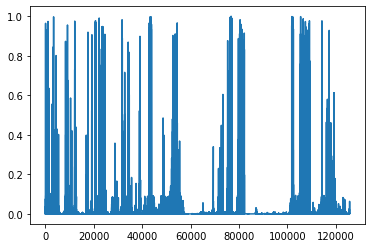

In [75]:
plt.plot(my_vec)

In [68]:
my_vec

Array([[ True,  True,  True, ...,  True,  True,  True]], dtype=bool)

In [58]:
my_ws[0]

for n_prot in my_legend.keys():
    my_legend[n_prot] = [0] + list(numpy.cumsum(my_legend[n_prot]))

my_legend

{0: [0, 24299, 70902, 160764], 1: [0, 125701, 229098, 289236]}

In [ ]:
def load_ph_data(obs_names, ph_vals, ns_prot, ns, gs, pH_weights, g_exp = None, sigma_exp = None):
    """
    Load pH data from multiple simulations at constant pH.

    Parameters
    
    """

    # 1. build a table for average values and standard deviations on the mean

    table_av = numpy.zeros((len(obs_names), len(ph_vals)))
    table_std = + table_av

    for i, obs_name in enumerate(obs_names):
        for j, ph in enumerate(ph_vals):
            # first index observable, second index ph
            if obs_name in gs[ph].columns:
                table_av[i, j] = np.mean(np.array(gs[ph][obs_name]))
                table_std[i, j] = np.std(np.array(gs[ph][obs_name]))/np.sqrt(len(gs[ph][obs_name]))
    
    if g_exp is None: g_exp = table_av
    if sigma_exp is None: sigma_exp = table_std

    # 2. protonation states

    for ph in ns.keys(): ns[ph] = np.array(ns[ph])

    unique_ns = []
    for ph in ns.keys(): unique_ns.append(np.unique(ns[ph]))
    unique_ns = np.unique(np.array(unique_ns))

    # 3. observables

    my_gs = {}

    for n_prot in unique_ns:
        n_prot = int(n_prot)
        my_gs[n_prot] = []
        for ph in ph_vals:
            # my_gs[n_prot].append(np.array(gs[ph].iloc[ns[ph] == n_prot].loc[0][obs_names]))
            # my_gs[n_prot].append(gs[ph][ns[ph].to_numpy() == n_prot])
            my_gs[n_prot].append(np.array(gs[ph])[ns[ph] == n_prot])
        my_gs[n_prot] = np.vstack(my_gs[n_prot])
        # WATCH OUT: you could have some missing observables for a given pH
        # False! You can always compute any observable from a constant-pH simulation

    # 4. 

    return Ph_data(table_av, table_std, my_gs, bias, unique_ns, ph_vals, obs_names)#, legend_matrix)


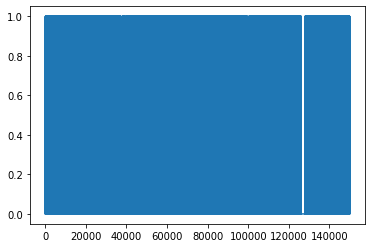

In [ ]:
gs[ph]

plt.plot(ns[ph])

In [38]:
len(ns[ph][ns[ph] == n_prot])

89862

In [ ]:
np.array(gs[ph])[ns[ph] == n_prot]

for n_prot in ns_prot:
    for ph in ph_vals:
        weights[ph][ns[ph] == n_prot]

Array([0.087577, 0.080756, 0.047577, ..., 0.004118, 0.001836, 0.002652],      dtype=float64)

In [41]:
[ns[ph] == n_prot]

[Array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)]

In [43]:
np.array(gs[ph])[ns[ph] == n_prot].shape

# np.array(gs[ph].iloc[ns[ph] == n_prot].loc[0][obs_names])

(89862, 2)

In [23]:
my_gs = {}

for n_prot in ns_prot:
    n_prot = int(n_prot)
    my_gs[n_prot] = []
    for ph in ph_vals:
        my_gs[n_prot].append(np.array(gs[ph].iloc[ns[ph] == n_prot].loc[0][obs_names]))
        my_gs[n_prot].append(gs[ph][ns[ph].to_numpy() == n_prot])
    my_gs[n_prot] = np.vstack(my_gs[n_prot])

KeyError: 0

In [61]:
for n_prot in [0, 1]:
    for ph in ph_vals:
        print(len(ws[n_prot][ph]), np.sum(ws[n_prot][ph]))

24299 111.009233
46603 1107.751555
89862 2921.476593
125701 1426.522845
103397 3837.889371
60138 1252.275392


In [60]:
ws = {}

for prot in [0, 1]:
    ws[prot] = {}
    for ph in ph_vals:
        my_gs = gs[ph][ns[ph].to_numpy() == prot]
        ws[prot][ph] = np.array(my_gs['weight'])

In [58]:
ws[prot][ph]

15        0.013055
17        0.000189
19        0.013907
23        0.012754
24        0.031341
            ...   
149965    0.004634
149966    0.004311
149975    0.006636
149979    0.002940
149989    0.005178
Name: weight, Length: 60138, dtype: float64

In [7]:
ws = {}
obs = {}

for prot in [0, 1]:
    ws[prot] = {}
    obs[prot] = {}
    for ph in ph_vals:
        my_gs = gs[ph][ns[ph].to_numpy() == prot]
        obs[prot][ph] = np.array(my_gs[['chi', 'eRMSD']])
        ws[prot][ph] = np.array(my_gs['weight'])
        ws[prot][ph] /= np.sum(ws[prot][ph])

print(obs[0][3.5].shape, ws[0][3.5].shape)

n_prot = 1

avs = {}
for ph in ph_vals:
    avs[ph] = np.average(obs[n_prot][ph], weights=ws[n_prot][ph], axis=0)

print(avs)

(24299, 2) (24299,)
{3.5: Array([0.83785604, 1.55566448], dtype=float64), 4.0: Array([0.13798794, 1.36339214], dtype=float64), 4.5: Array([-1.71027328,  1.1049051 ], dtype=float64)}


In [23]:
obs_names = df.columns[1:3]

In [47]:
ph

3.5

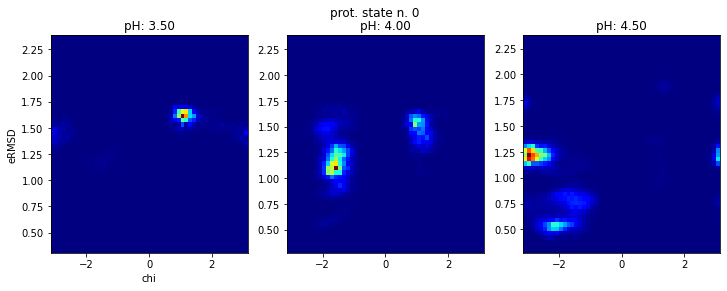

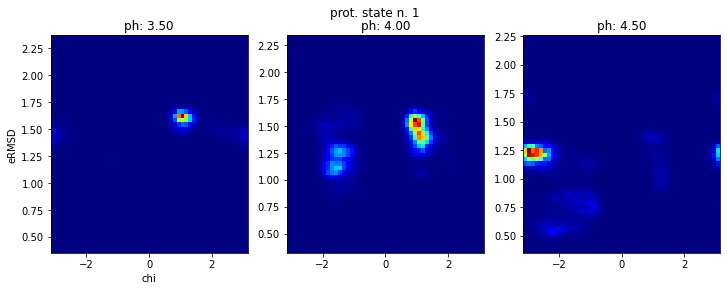

In [51]:
n_prot = 0

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
plt.suptitle('prot. state n. %i' % n_prot)

for i, ph in enumerate(ph_vals):
    axs[i].hist2d(obs[n_prot][ph][:, 0], obs[n_prot][ph][:, 1], weights=ws[n_prot][ph], bins=50, cmap='jet')[2]
    axs[i].set_title('pH: %.2f' % ph)
axs[0].set_xlabel(obs_names[0])
axs[0].set_ylabel(obs_names[1])

plt.savefig('Images/mismatch_2d_%i.pdf' % n_prot, format='pdf', bbox_inches='tight')

n_prot = 1

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
plt.suptitle('prot. state n. %i' % n_prot)

for i, ph in enumerate(ph_vals):
    axs[i].hist2d(obs[n_prot][ph][:, 0], obs[n_prot][ph][:, 1], weights=ws[n_prot][ph], bins=50, cmap='jet')[2]
    axs[i].set_title('ph: %.2f' % ph)
axs[0].set_xlabel(obs_names[0])
axs[0].set_ylabel(obs_names[1])

plt.savefig('Images/mismatch_2d_%i.pdf' % n_prot, format='pdf', bbox_inches='tight')

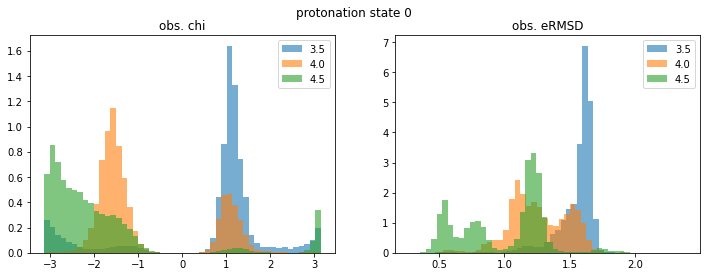

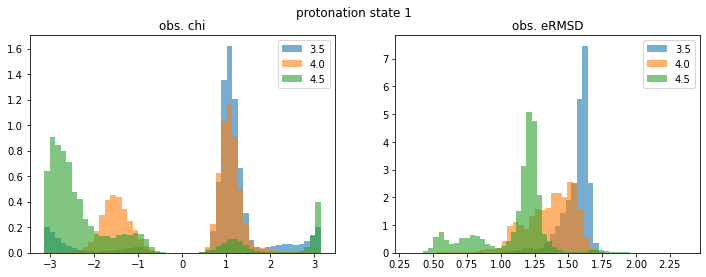

In [32]:
for n_prot in [0, 1]:

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    fig.suptitle('protonation state %i' % n_prot)

    i_obs = 0
    for ph in ph_vals:
        # density = True not needed because I have normalized weights
        axs[0].hist(obs[n_prot][ph][:, i_obs], weights=ws[n_prot][ph], alpha=0.6, bins=50, label=ph, density=True)[0]
    axs[0].set_title('obs. %s' % obs_names[i_obs])
    axs[0].legend()

    i_obs = 1
    for ph in ph_vals:
        # density = True not needed because I have normalized weights
        axs[1].hist(obs[n_prot][ph][:, i_obs], weights=ws[n_prot][ph], alpha=0.6, bins=50, label=ph, density=True)[0]
    axs[1].set_title('obs. %s' % obs_names[i_obs])
    axs[1].legend()

    # plt.savefig('Images/mismatch_%i.pdf' % n_prot, format='pdf', bbox_inches='tight')

Array(0., dtype=float64)

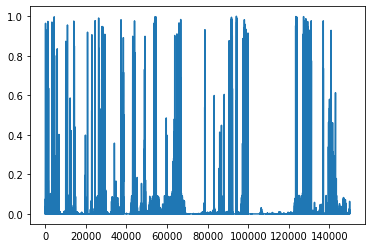

In [15]:
plt.plot(gs[3.5]['weight'])
# plt.yscale('symlog')

np.min(np.array(gs[3.5]['weight']))


In [16]:
gs[3.5]['weight'][ns[3.5] == 0]

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

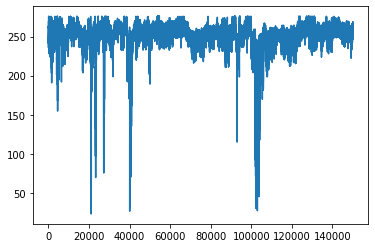

In [7]:
plt.plot(gs[3.5]['metad.bias'])

**CRITICAL ISSUE**

How to pass from the probability of a configuration sampled in a simulation at constant pH to that of the same configuration but in the corresponding ensemble at fixed protonation state?

1. from `metad.bias` $V(x)$ to weights (through $e^{\beta V(x)}$ ?) in the constant-pH simulations
2. from the constant-pH ensembles to the ensembles with given protonation state: I should weight equally each pH, namely: if at pH 3.5 the deprotonated state has prob. 0.7 and the protonated state 0.3 and at pH 4.0 the deprotonated 0.5 and the protonated 0.5, then I take deprotonated states from multiple pH values with the same weight (is it right?)

No, the fact that we have a different number of configurations at different pH should not impact the single weights (compare with and without `/tot[ph][int(n_prot)]` in `vals = weights[ph][ns[ph] == n_prot]#/tot[ph][int(n_prot)]`

- if each constant pH MD simulation has been performed with plain MD, then just collect each configuration at given protonation state from each constant pH simulation; what happens when metadynamics is used? This should mean that the weight is the (float) number of times each configuration has been sampled, but this is not invariant by constant shift of a potential value...?

It's like when I want to build a single ensemble from multiple simulations at different temperature (WHAM when replica exchange is performed) ??

- problem when simulations at different pH values have a (big) difference in the autocorrelation times!

The grand canonical ensemble "includes" the canonical distributions at the two protonation states.

The **question** is: how should I compute the average value of the k-th observable over the canonical ensemble at given protonation state j? The advantage comes from the fact that I can improve my estimation of the average by collecting several samples of the j-th canonical distribution, coming from different pH values (the Hamiltonian does not depend on the pH).

I could weight the contribution from each pH value equally, indeed they are all samplings of the same canonical distribution, but it may happen that for some pH values the j-th protonation state might be very poorly sampled, so I could perform a weighted average such that I count more the contributions from the pH values at which I have more configurations

\begin{equation}
\langle g_k \rangle_{P_j} = ?
\end{equation}

In [ ]:
obs_names = ['chi', 'eRMSD']
ph_vals = [3.5, 4.0, 4.5]

# 0. read data
ns = {}
gs = {}
bias = {}

for ph in ph_vals:
    ns[ph] = pandas.read_csv(path + 'A5mer_pH0%.2f.occ' % ph, header=None).iloc[:, 0]
    
    df = pandas.read_csv(path + 'COLVAR_REWEIGHT_0%.2f' % ph, header=3, sep=' ').iloc[:, :4]

    # df.columns = ['time', 'chi', 'eRMSD', 'bias']
    df.columns = list(pandas.read_csv(path + 'COLVAR_REWEIGHT_0%.2f' % ph, nrows=0, sep=' '))[2:]
    
    gs[ph] = df[obs_names]
    bias[ph] = df['metad.bias']


    

In [11]:
data = load_ph_data(obs_names, ph_vals, ns, gs, bias)

In [120]:
ns[3.5]

Array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [12]:
ns_prot = data.ns_prot

In [13]:
import numpy as np

In [14]:
weights = {}
tot = {}

for ph in ph_vals:
    weights[ph] = np.exp(np.array(bias[ph])/300)  # is it correct?? fix it!!
    weights[ph] /= np.sum(weights[ph])
    tot[ph] = {}
    for n in ns_prot:
        tot[ph][int(n)] = np.sum(weights[ph][ns[ph] == n])

weights

{3.5: array([6.66394889e-06, 6.71593129e-06, 6.67631981e-06, ...,
        6.92391018e-06, 6.80949403e-06, 6.85224664e-06]),
 4.0: array([6.82777643e-06, 6.70567448e-06, 6.60738651e-06, ...,
        6.64681265e-06, 6.60932219e-06, 6.55006619e-06]),
 4.5: array([6.95972757e-06, 6.95502659e-06, 6.92442973e-06, ...,
        6.78465304e-06, 6.73915142e-06, 6.75983117e-06])}

In [37]:
# compute weights from well-tempered metadynamics
eff_beta = 0.4  # 1/300  # put the correct value

weights = {}

for ph in ph_vals:
    weights[ph] = np.exp(eff_beta*np.array(bias[ph]))
    weights[ph] /= np.sum(weights[ph])

# collect configurations at fixed protonation state
prot_weights = []

for n_prot in ns_prot:
    prot_weights.append([])
    for ph in ph_vals:
        vals = weights[ph][ns[ph] == n_prot]
        prot_weights[-1].extend(vals)
    prot_weights[-1] = np.array(prot_weights[-1])
    prot_weights[-1] /= np.sum(prot_weights[-1])

In [ ]:
# compute weights from well-tempered metadynamics
eff_beta = 0.4

weights = {}

for ph in ph_vals:
    weights[ph] = np.exp(eff_beta*np.array(bias[ph]))
    # weights[ph] /= np.sum(weights[ph])

# collect configurations at fixed protonation state
is_equal_contribution = False
if is_equal_contribution: tot = {}

for ph in ph_vals:
    if is_equal_contribution:
        tot[ph] = {}
        for n in ns_prot:
            tot[ph][int(n)] = np.sum(weights[ph][ns[ph] == n])

prot_weights = []

for n_prot in ns_prot:
    prot_weights.append([])
    for ph in ph_vals:
        vals = weights[ph][ns[ph] == n_prot]
        if is_equal_contribution: vals /= tot[ph][int(n_prot)]
        prot_weights[-1].extend(vals)
    prot_weights[-1] = np.array(prot_weights[-1])
    prot_weights[-1] /= np.sum(prot_weights[-1])


In [36]:
print(prot_weights[0])

[5.63085064e-08 7.49573747e-08 3.23254783e-07 ... 1.13394232e-06
 5.05707690e-07 7.30425188e-07]


[4.30177893e-08 5.72648922e-08 2.46955692e-07 ... 9.90341272e-07
 4.41665497e-07 6.37925052e-07]


1.0

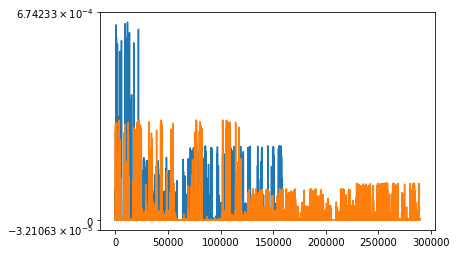

In [38]:
plt.plot(prot_weights[0])

print(prot_weights[0])

plt.plot(prot_weights[1])

plt.yscale('symlog')

np.sum(prot_weights[1])

In [ ]:
for ph in ns.keys(): ns[ph] = np.array(ns[ph])

unique_ns = []
for ph in ns.keys(): unique_ns.append(np.unique(ns[ph]))
unique_ns = np.unique(np.array(unique_ns))

print(unique_ns)

my_gs = {}

for n_prot in unique_ns:
    n_prot = int(n_prot)
    my_gs[n_prot] = []
    for ph in ph_vals:
        my_gs[n_prot].append(np.array(gs[ph].iloc[ns[ph] == n_prot].loc[0][obs_names]))
    my_gs[n_prot] = np.vstack(my_gs[n_prot])
    # WATCH OUT: you could have some missing observables for a given pH

my_gs[0]

[0 1]


Array([[-1.258657,  0.671871],
       [-1.258657,  0.671871],
       [-1.258657,  0.671871],
       ...,
       [-1.183639,  0.677856],
       [-1.183639,  0.677856],
       [-1.183639,  0.677856]], dtype=float64)

<BarContainer object of 400 artists>

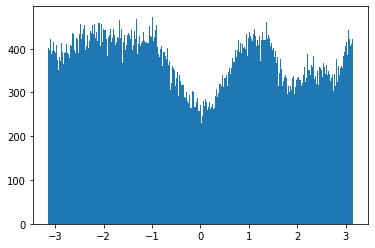

In [8]:
plt.hist(gs[3.5]['chi'], bins=400)[2]

(array([89862.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 60138.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

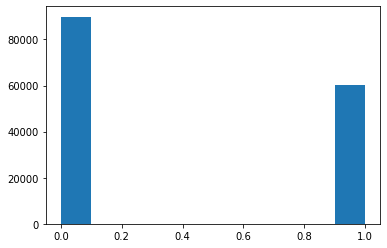

In [15]:
plt.hist(ns[4.5])

In [ ]:
class Ph_data():
    def __init__(self, path, ph_vals):

        self.ph_vals = ph_vals

        ns = {}
        gs = {}

        for ph in ph_vals:
            ns[ph] = pandas.read_csv(path + 'A5mer_pH0%.2f.occ' % ph, header=None).iloc[:, 0]
            
            df = pandas.read_csv(path + 'COLVAR_REWEIGHT_0%.2f' % ph, header=3, sep=' ').iloc[:, :4]
            df.columns = ['time', 'chi', 'eRMSD', 'bias']
            gs[ph] = df



In [ ]:
ph_values = list(gs.keys())

# fake values (synthetic, then compute them by biasing initial time series)
g_exp = []
sigma_exp = []

for ph in ph_values:
    my_vals = np.array(gs[ph][['chi', 'eRMSD']])
    g_exp.append(np.mean(my_vals, axis=0))
    sigma_exp.append(np.std(my_vals, axis=0)/np.sqrt(my_vals.shape[0]))

g_exp = np.array(g_exp).T
sigma_exp = np.array(sigma_exp).T
# first index observable, second index pH

print(g_exp.shape)

assert g_exp.shape[1] == len(ph_values), 'mismatch in g_exp'
assert sigma_exp.shape == g_exp.shape, 'mismatch between g_exp and sigma_exp'

g_exp_vec = Manage_indices.flatten(g_exp)
sigma_exp_vec = Manage_indices.flatten(sigma_exp)



(2, 3)


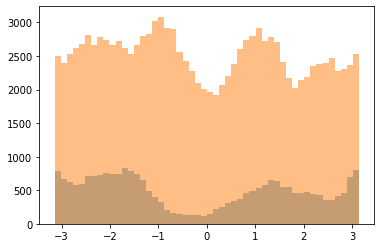

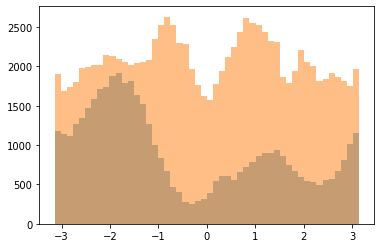

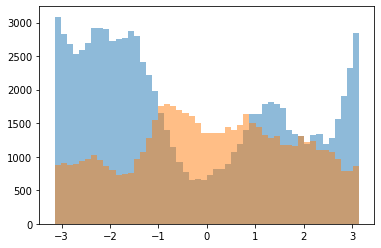

In [47]:
ph = ph_values[0]

for ph in ph_values:
    plt.figure()
    if_density = False
    plt.hist(gs[ph]['chi'][ns[ph] == 0], bins=50, alpha=0.5, density=if_density)[2]
    plt.hist(gs[ph]['chi'][ns[ph] == 1], bins=50, alpha=0.5, density=if_density)[2]



**crucial point!**

when you compute the average value of the k-th observable at pH n. i, this is

\begin{equation}
\sum_j w_{ij} \langle g_k(x) \rangle_{P_j}
\end{equation}

so you put together the values of the k-th observable at given protonation state $P_j$ independently on which simulation at constant pH they come from 

In [72]:
my_gs = {}

for ph in ph_values:
    my_vals = np.array(gs[ph][['chi', 'eRMSD']])
    for n in unique_ns:
        my_gs[n].extend(my_vals[ns[ph] == n])


TypeError: unhashable type: 'jaxlib.xla_extension.ArrayImpl'

In [ ]:
new_gs = {}

# here we have only ns == 0 or ns == 1
for ph in ph_values:
    new_gs['chi'].append(gs[ph]['chi'][ns[ph] == 0])

